In [1]:
import pandas as pd
import glob
import os

def combine_and_aggregate(input_folder="data", output_file="combined_data.csv"):
    """
    Reads all CSV files in `input_folder`, concatenates them, and computes
    the mean Vehicle Count and mean Density grouped by (Time, Detector ID, Scenario).
    Saves the result to `output_file`.
    """
    # 1. Gather all relevant CSV files
    csv_files = glob.glob(os.path.join(input_folder, "data_*.csv"))
    
    # 2. Concatenate all files into one DataFrame
    all_dfs = []
    for f in csv_files:
        # Read each CSV; if semicolon-delimited, add sep=';' as needed
        df = pd.read_csv(f)
        all_dfs.append(df)
    
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    # 3. Group by (Time (s), Detector ID, Scenario) and compute mean over seeds
    grouped = (
        combined_df
        .groupby(["Time (s)", "Detector ID", "Scenario"], as_index=False)
        .agg({
            "Vehicle Count": "mean",
            "Density (veh/km)": "mean"
        })
    )
    
    # Optionally rename columns to something like 'Mean Vehicle Count' or 'Average Density'
    grouped.rename(columns={
        "Vehicle Count": "Mean Vehicle Count",
        "Density (veh/km)": "Mean Density (veh/km)"
    }, inplace=True)
    
    # 4. Save the final DataFrame
    grouped.to_csv(output_file, index=False)
    print(f"Aggregated data saved to {output_file}")

if __name__ == "__main__":
    combine_and_aggregate(
        input_folder="data", 
        output_file="data/combined_data.csv"
    )


Aggregated data saved to data/combined_data.csv


In [2]:
import pandas as pd
import xml.etree.ElementTree as ET

DETECTORS_FILE = "lanedetectors.add.xml" 
DATA_FILE = "data/combined_data.csv"  
BIN_SIZE = 300  # 5-minute intervals
T_START = 0  # Arbitrary start time for binning

def main():
    global combined_results
    # Load detectors from XML file
    detector_ids = load_detectors_from_xml(DETECTORS_FILE)
    cross_section_map = parse_cross_sections(detector_ids)

    # Aggregate data with binning
    combined_results = combined_output(DATA_FILE, cross_section_map, bin_size=BIN_SIZE, t_start=T_START)

    print(combined_results.head())

    # Save to CSV
    combined_results.to_csv("data/combined_datav2.csv", index=False)
    print("Data saved to data/combined_datav2.csv")

    return combined_results


def parse_cross_sections(detector_ids):
    """Group detectors into edges by excluding the middle part of the detector ID."""
    cross_section_map = {}
    for detector_id in detector_ids:
        # Extract edge and position by removing the middle part (e.g., E1_0_1000m -> E1_1000m)
        parts = detector_id.split("_")
        if len(parts) == 3:
            edge = f"{parts[0]}_{parts[2]}"  # Combine the first and last parts
        else:
            edge = detector_id  # Fallback for unexpected formats
        cross_section_map[detector_id] = edge
    return cross_section_map

def load_detectors_from_xml(detectors_file):
    """Load detector IDs from the XML file."""
    tree = ET.parse(detectors_file)
    root = tree.getroot()
    detector_ids = [detector.get("id") for detector in root.findall("laneAreaDetector")]
    return detector_ids

def combined_output(csv_file, cs_map, bin_size=300, t_start=0):
    """Aggregates data into time bins and merges detector IDs."""

    # Load CSV file
    df = pd.read_csv(csv_file)

    # Rename columns for consistency
    df.rename(columns={
        "Time (s)": "time",
        "Detector ID": "detectorID",
        "Mean Vehicle Count": "count",
        "Mean Density (veh/km)": "density",
        "Scenario": "scenario"
    }, inplace=True)

    # Map Detector IDs to their simplified names
    df["detectorID"] = df["detectorID"].map(cs_map)

    # Ensure only times from `t_start` onwards are considered
    df = df[df["time"] >= t_start]

    # Create `time_bin` based on `t_start` and `bin_size`
    df["time_bin"] = ((df["time"] - t_start) // bin_size) * bin_size + t_start

    # Ensure we don't mix scenarios when aggregating
    grouped = df.groupby(["time_bin", "detectorID", "scenario"], as_index=False)
    
    aggregated_df = grouped.agg(
        count=("count", "sum"),  # Sum of vehicle counts
        density=("density", "mean"),  # Average density
    )

    return aggregated_df

if __name__ == "__main__":
    main()

   time_bin detectorID scenario   count    density
0       0.0      E0_0m   attack  1218.4  20.374582
1       0.0      E0_0m     base  1218.4  20.374582
2       0.0   E0_1000m   attack  1148.6  19.207358
3       0.0   E0_1000m     base  1148.6  19.207358
4       0.0    E0_100m   attack  1221.8  20.431438
Data saved to data/combined_datav2.csv


In [3]:
def calculate_ratios(data):
    """Calculate Speed Performance Ratio (SPR) and Flow Ratio (FR)."""

    # Separate attack and base scenarios
    attack_data = data[data["scenario"] == "attack"]
    base_data = data[data["scenario"] == "base"]

    # Merge attack and base data for comparison (EXCLUDING scenario from the merge key)
    merged_data = pd.merge(
        attack_data,
        base_data,
        on=["time_bin", "detectorID"],  # Corrected merge condition
        suffixes=("_attack", "_base")
    )

    # Debugging: Check merged data
    print("Merged Data Preview:")
    print(merged_data.head())

    # Select and format output columns
    output_data = merged_data[[
        "time_bin",
        "detectorID",
        "density_attack",
        "density_base"
    ]].round(2)  # Round all numeric columns to 2 decimal places

    return output_data

# Load combined data from CSV
comb_results = pd.read_csv("data/combined_datav2.csv")

# Calculate ratios and save to CSV
ratios = calculate_ratios(comb_results)
ratios.to_csv("data/combined_datav3.csv", index=False)
print("Ratios saved to data/combined_datav3.csv")


Merged Data Preview:
   time_bin detectorID scenario_attack  count_attack  density_attack  \
0       0.0      E0_0m          attack        1218.4       20.374582   
1       0.0   E0_1000m          attack        1148.6       19.207358   
2       0.0    E0_100m          attack        1221.8       20.431438   
3       0.0   E0_1100m          attack        1141.0       19.080268   
4       0.0   E0_1200m          attack        1128.4       18.869565   

  scenario_base  count_base  density_base  
0          base      1218.4     20.374582  
1          base      1148.6     19.207358  
2          base      1221.8     20.431438  
3          base      1141.0     19.080268  
4          base      1128.4     18.869565  
Ratios saved to data/combined_datav3.csv


In [4]:
ratios = pd.read_csv("data/combined_datav3.csv")

# convert veh/km/lane to vveh/mile/lane for density
ratios['density_attack'] = ratios['density_attack'] * 1.60934
ratios['density_base'] = ratios['density_base'] * 1.60934

# Define LOS classification function for urban freeway density
def classify_LOS(density):
    if density <= 11:
        return "A"
    elif 11 < density <= 18:
        return "B"
    elif 18 < density <= 26:
        return "C"
    elif 26 < density <= 35:
        return "D"
    elif 35 < density <= 45:
        return "E"
    else:
        return "F"
    
# Apply LOS classification to both scenarios
ratios["LOS_attack"] = ratios["density_attack"].apply(classify_LOS)
ratios["LOS_base"] = ratios["density_base"].apply(classify_LOS)

# Define function to assign distance based on detectorID
def assign_distance(detector_id):
    """Assigns distance based on the detectorID."""
    if detector_id.startswith("E0_"):
        base_distance = 0
    elif detector_id.startswith("E1_"):
        base_distance = 2000
    elif detector_id.startswith("E2_"):
        base_distance = 4000
    else:
        return None  # If the format doesn't match expected values

    # Extract the numeric part of the detectorID (distance suffix)
    suffix_distance = int(detector_id.split("_")[1][:-1])  # Extract number before 'm'
    
    return base_distance + suffix_distance

ratios["distance"] = ratios["detectorID"].apply(assign_distance)

# Sort the DataFrame
ratios_sorted = ratios.sort_values(by=["time_bin", "distance"], ascending=[True, True])

print(ratios_sorted.head())

# Drop helper columns used for sorting
# ratios_sorted = ratios_sorted.drop(columns=["road", "distance"])



# Save to CSV
ratios_sorted.to_csv("data/combined_datav4.csv", index=False)
print("Ratios saved to data/combined_datav4.csv")



    time_bin detectorID  density_attack  density_base LOS_attack LOS_base  \
0        0.0      E0_0m       32.782256     32.782256          D        D   
2        0.0    E0_100m       32.878816     32.878816          D        D   
13       0.0    E0_200m       32.589135     32.589135          D        D   
24       0.0    E0_300m       32.444294     32.444294          D        D   
35       0.0    E0_400m       32.235080     32.235080          D        D   

    distance  
0          0  
2        100  
13       200  
24       300  
35       400  
Ratios saved to data/combined_datav4.csv


/tmp/ipykernel_1387787/362048544.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return pivot_df.applymap(lambda x: LOS_map[x] if pd.notnull(x) else np.nan)
/tmp/ipykernel_1387787/362048544.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1])  # Leave room on the right for cbar


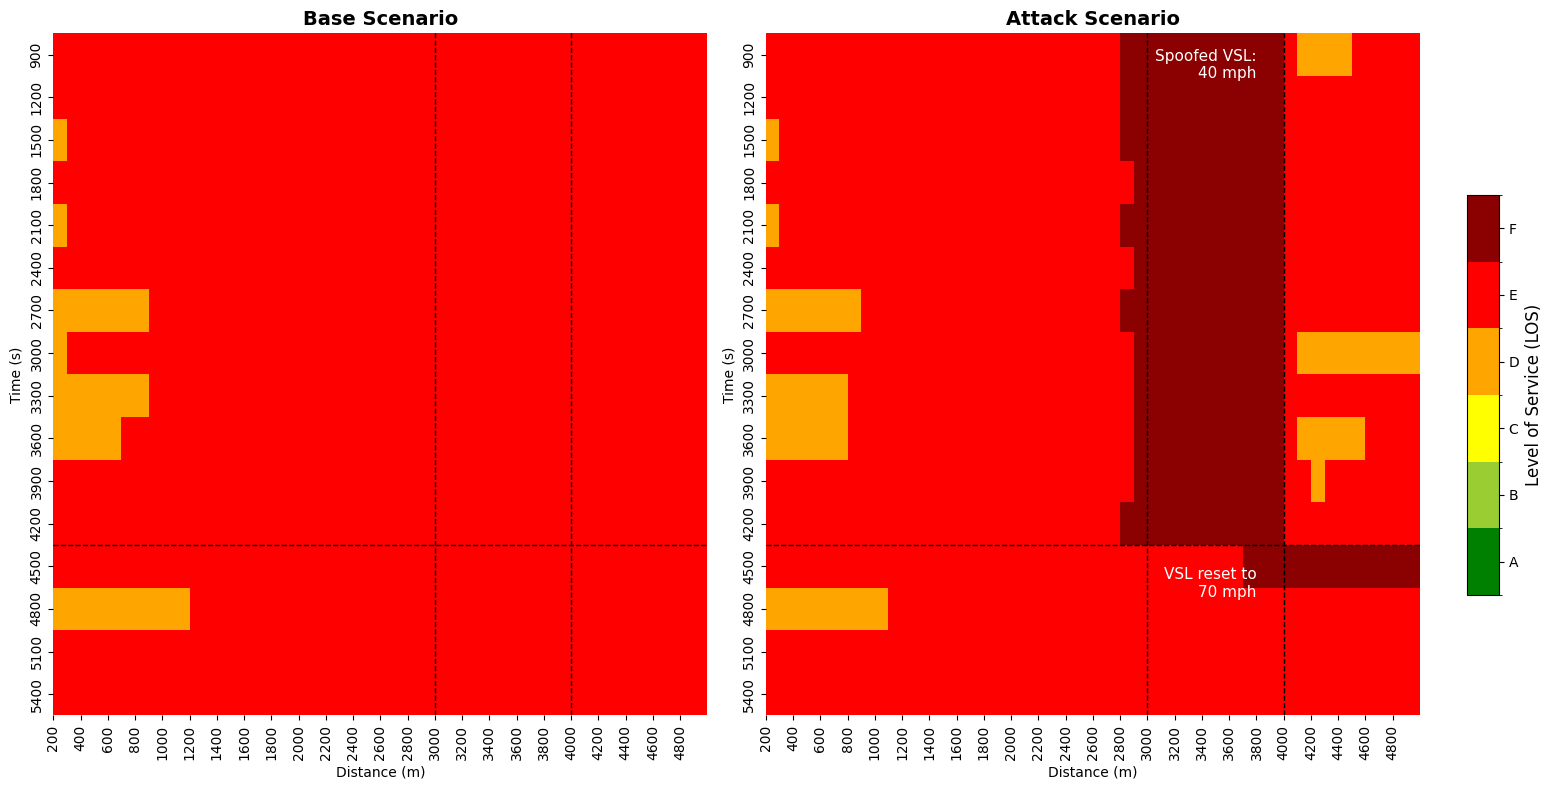

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# ------------------------------------------------------------------------
# 1. Read Data
# ------------------------------------------------------------------------
file_path = "data/combined_datav4.csv"
df = pd.read_csv(file_path)

# Convert time_bin and distance to int if needed
df["time_bin"] = df["time_bin"].astype(int)
df["distance"] = df["distance"].astype(int)

# ------------------------------------------------------------------------
# 2. Split Attack vs. Base and rename LOS columns for pivoting
# ------------------------------------------------------------------------
df_base = df[["time_bin", "distance", "LOS_base"]].copy()
df_attack = df[["time_bin", "distance", "LOS_attack"]].copy()

df_base.rename(columns={"LOS_base": "LOS"}, inplace=True)
df_attack.rename(columns={"LOS_attack": "LOS"}, inplace=True)

# ------------------------------------------------------------------------
# 3. Filter by distance/time range (adjust if needed)
# ------------------------------------------------------------------------
distance_start = 200
distance_end   = 4900
time_start     = 900
time_end       = 5400

df_base = df_base[
    (df_base["distance"] >= distance_start) &
    (df_base["distance"] <= distance_end) &
    (df_base["time_bin"] >= time_start) &
    (df_base["time_bin"] <= time_end)
]

df_attack = df_attack[
    (df_attack["distance"] >= distance_start) &
    (df_attack["distance"] <= distance_end) &
    (df_attack["time_bin"] >= time_start) &
    (df_attack["time_bin"] <= time_end)
]

# ------------------------------------------------------------------------
# 4. Pivot into matrices: index=time_bin, columns=distance, values=LOS
# ------------------------------------------------------------------------
pivot_base   = df_base.pivot(index="time_bin", columns="distance", values="LOS")
pivot_attack = df_attack.pivot(index="time_bin", columns="distance", values="LOS")

# ------------------------------------------------------------------------
# 5. Map LOS (A–F) to numeric
# ------------------------------------------------------------------------
LOS_map = {"A":1, "B":2, "C":3, "D":4, "E":5, "F":6}

def map_LOS_to_numeric(pivot_df):
    return pivot_df.applymap(lambda x: LOS_map[x] if pd.notnull(x) else np.nan)

base_numeric   = map_LOS_to_numeric(pivot_base)
attack_numeric = map_LOS_to_numeric(pivot_attack)

# ------------------------------------------------------------------------
# 6. Create a discrete colormap for LOS
# ------------------------------------------------------------------------
los_colors = ["green", "yellowgreen", "yellow", "orange", "red", "darkred"]
cmap = ListedColormap(los_colors)
bounds = [0.5,1.5,2.5,3.5,4.5,5.5,6.5]
norm = BoundaryNorm(bounds, cmap.N)

# ------------------------------------------------------------------------
# 7. Plot the two heatmaps: BASE on the LEFT, ATTACK on the RIGHT
# ------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

# --- BASE Scenario (left) ---
sns.heatmap(
    base_numeric,
    ax=axes[0],
    cmap=cmap,
    norm=norm,
    cbar=False,
    square=False
)
axes[0].set_title("Base Scenario", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Distance (m)")
axes[0].set_ylabel("Time (s)")  # show y-label on base scenario

# Example: label x‐ticks more sparsely
axes[0].set_xticks(np.arange(0, len(pivot_base.columns), 2))
axes[0].set_xticklabels(pivot_base.columns[::2], rotation=90)

# --- ATTACK Scenario (right) ---
sns.heatmap(
    attack_numeric,
    ax=axes[1],
    cmap=cmap,
    norm=norm,
    cbar=False,
    square=False
)
axes[1].set_title("Attack Scenario", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Distance (m)")
axes[1].set_ylabel("Time (s)")  # explicitly add y-label if desired

# Example: label x‐ticks more sparsely
axes[1].set_xticks(np.arange(0, len(pivot_base.columns), 2))
axes[1].set_xticklabels(pivot_base.columns[::2], rotation=90)

# axes is your array of subplots, e.g. axes[0] for base, axes[1] for attack

col_index_3000 = pivot_attack.columns.get_loc(3000)
col_index_4000 = pivot_attack.columns.get_loc(4000)
row_index_4500 = pivot_attack.index.get_loc(4500)

for ax in axes:
    # Vertical line at distance=3000
    ax.axvline(x=col_index_3000, color="k", linestyle="--", lw=1)
    # Vertical line at distance=4000
    ax.axvline(x=col_index_4000, color="k", linestyle="--", lw=1)
    # Horizontal line at time=2400
    ax.axhline(y=row_index_4500, color="k", linestyle="--", lw=1)


# ------------------------------------------------------------------------
#  Add the same text (and optional arrow) to BOTH subplots
# ------------------------------------------------------------------------
axes[1].text(
    0.75, 0.93, "Spoofed VSL:\n40 mph",
    transform=ax.transAxes,
    ha="right", va="bottom",
    color="white", fontsize=11
)
axes[1].text(
    0.75, 0.17, "VSL reset to\n70 mph",
    transform=ax.transAxes,
    ha="right", va="bottom",
    color="white", fontsize=11
)

# ------------------------------------------------------------------------
# 8. Add a colorbar on the far right
# ------------------------------------------------------------------------
# By default, fig.colorbar() tries to place the colorbar in the middle.
# We can give it its own Axes to ensure it's on the far right:
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]

cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cbar_ax,
    orientation='vertical'
)

# Label ticks A-F
cbar.set_ticks([1,2,3,4,5,6])
cbar.set_ticklabels(["A", "B", "C", "D", "E", "F"])
cbar.set_label("Level of Service (LOS)", fontsize=12)

plt.tight_layout(rect=[0, 0, 0.90, 1])  # Leave room on the right for cbar
plt.savefig("LOS30.png", dpi=300, bbox_inches="tight")
plt.show()
